In [10]:
from pypde import *
import matplotlib.pyplot as plt
initplot()

class Temperature(Integrator):
    CONFIG={
        "shape": (50,50),
        "bases": ("CN","CD"),
        "kappa": 1.0,
        "dt": 0.2,
        "ndim": 2,
        "tsave": 0.1,
    }
    def __init__(self,**kwargs):
        Integrator.__init__(self)
        self.__dict__.update(**self.CONFIG)
        self.__dict__.update(**kwargs)
        # Field
        self.field = Field(self.shape,self.bases)
        # Boundary Conditions
        self.setup_fieldbc()
        # Solver
        self.setup_solver()
        # Initialize field
        self.init_field()
        self.field.save()
        
        # Space for derivatives
        self.deriv_field = Field(self.shape,("CH","CH"))
        
    def setup_fieldbc(self):
        ''' Setup Inhomogeneous field'''
        # Boundary Conditions T 1, 0
        bc = np.zeros((self.shape[0],2))
        bc[:,0] = 1.0
        self.fieldbc = FieldBC(self.shape,self.bases,axis=1)
        self.fieldbc.add_bc(bc)
        
    def setup_solver(self):
        from pypde.templates.hholtz import solverplan_hholtz2d_adi
        self.solver = solverplan_hholtz2d_adi(
            self.shape,self.bases,lam=self.dt*self.kappa)
    
    def init_field(self):
        #self.field.v = -self.fieldbc.v
        self.field.v[:] = 0
        self.field.forward()
        self.field.backward()
    
    @property
    @memoized
    def bc_d2Tdz2(self):
        return derivative_field(self.fieldbc,deriv=(0,2))
    
    @property
    @memoized
    def bc_dTdz(self):
        return derivative_field(self.fieldbc,deriv=(0,1))
        #return -0.5
                                 
    def nonlin(self,ux,uz):
        '''
        Returns field of nonlinear advection.
        Already transform into spectral space.
        
        ux,uz must contain fields in physical
        space (already back transformed)
        '''
        assert np.all([isinstance(i,Field)for i in [ux,uz]])
        
        # ux dTdx
        dTdx = grad( self.field, (1,0) )
        nonlin = ux.v*dTdx.v
        
        # uz dTdz
        dTdz = grad( self.field, (0,1) )
        nonlin += uz.v*dTdz.v
        
        # uz dTdz (from bc)
        nonlin += uz.v*self.bc_dTdz.v
        
        # Transform back
        self.deriv_field.v = nonlin
        self.deriv_field.forward()
        return self.deriv_field
                                 
    
    def update(self,ux_field=None,uz_field=None):
        ''' (1-D2)v = D2 v_bc + vold'''
        rhs = self.dt*self.kappa*self.bc_d2Tdz2.vhat
        if ux_field is not None and uz_field is not None:
            rhs -= self.dt*self.nonlin(ux_field,uz_field).vhat
        
        rhs  = self.solver.solve_rhs(  rhs )
        rhs += self.solver.solve_old(self.field.vhat)
        self.field.vhat[:] = self.solver.solve_lhs(rhs)

set color cycle ...
register goldfish colorbar as 'gfcmap' ...
update rc params to default ...


In [11]:
shape = (40,40)

T  = Temperature(shape=shape,bases=("CN","CD"))
ux = Field(shape,("CD","CD"))
uz = Field(shape,("CD","CD"))

x,y = T.field.x, T.field.y
xx,yy = np.meshgrid(x,y,indexing="ij")

## Set velocity fields

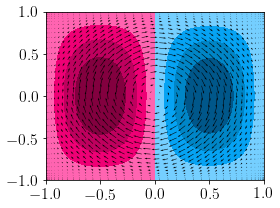

In [12]:
m,n = 1,1
ux.v =  2*np.cos(0.5*m*np.pi*xx)*np.sin(1.0*n*np.pi*yy)
uz.v = -2*np.sin(1.0*m*np.pi*xx)*np.cos(0.5*n*np.pi*yy)

plt.contourf(xx,yy,uz.v)
plt.quiver(xx,yy,ux.v,uz.v)
plt.show()


## Solve

In [8]:
#%%time

D = Temperature(shape=shape,dt=0.01,tsave=0.5,kappa=0.1)
D.iterate(10.0,ux_field = ux, uz_field=uz)

Time: 0.500
Time: 1.000
Time: 1.500
Time: 2.000
Time: 2.500
Time: 3.000
Time: 3.500
Time: 4.000
Time: 4.500
Time: 5.000
Time: 5.500
Time: 6.000
Time: 6.500
Time: 7.000
Time: 7.500
Time: 8.000
Time: 8.500
Time: 9.000
Time: 9.500
Time: 10.000
CPU times: user 3.01 s, sys: 130 ms, total: 3.14 s
Wall time: 2.96 s


Save animation to out/anim.mp4


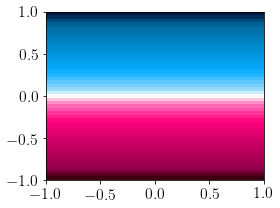

In [9]:
from IPython.display import HTML

#  Add inhomogeneous part
if D.field.V[0][0,0] < 0.1:
    for i,v in enumerate(D.field.V):
        D.field.V[i] += D.fieldbc.v

anim = D.field.animate(duration=4)
#plt.close("all")
HTML(anim.to_jshtml())
#plt.close("all")